In [98]:
import pandas as pd
import numpy as np

athletes_df = pd.read_csv("athletes.csv")

athletes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [99]:
# заполняем пропуски и корректриуем данные
athletes_df["dob"] = pd.to_datetime(athletes_df["dob"], errors="coerce")

athletes_df["dob"] = np.where(
    athletes_df["dob"] > pd.Timestamp.today(),
    athletes_df["dob"] - pd.DateOffset(years=100),
    athletes_df["dob"],
)

athletes_df["dob"] = athletes_df["dob"].fillna(
    athletes_df.groupby(["sex", "sport"])["dob"].transform("median")
)

for i in ['height', 'weight']:
    athletes_df[i] = athletes_df[i].fillna(athletes_df.groupby(['sex', 'sport'])[i].transform('median'))
    athletes_df[i] = athletes_df[i].fillna(athletes_df.groupby(['sex'])[i].transform('median'))


athletes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           11538 non-null  int64         
 1   name         11538 non-null  object        
 2   nationality  11538 non-null  object        
 3   sex          11538 non-null  object        
 4   dob          11538 non-null  datetime64[ns]
 5   height       11538 non-null  float64       
 6   weight       11538 non-null  float64       
 7   sport        11538 non-null  object        
 8   gold         11538 non-null  int64         
 9   silver       11538 non-null  int64         
 10  bronze       11538 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 991.7+ KB


/var/folders/mk/srk2d63n62qc5h8z461_xl000000gn/T/ipykernel_10792/1354360134.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  athletes_df["dob"] = pd.to_datetime(athletes_df["dob"], errors="coerce")


In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

features = athletes_df[['sex', 'sport', 'height', 'weight']]
X = pd.get_dummies(features.drop('sex', axis=1))

le.fit(features['sex'])
y = pd.Series(data=le.transform(features['sex'])) # 0 - female, 1 - male

# print(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

y_pred_proba[:5]

array([[0.02375106, 0.97624894],
       [0.56361821, 0.43638179],
       [0.10899993, 0.89100007],
       [0.03235796, 0.96764204],
       [0.54339917, 0.45660083]])

/var/folders/mk/srk2d63n62qc5h8z461_xl000000gn/T/ipykernel_10792/3614439645.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


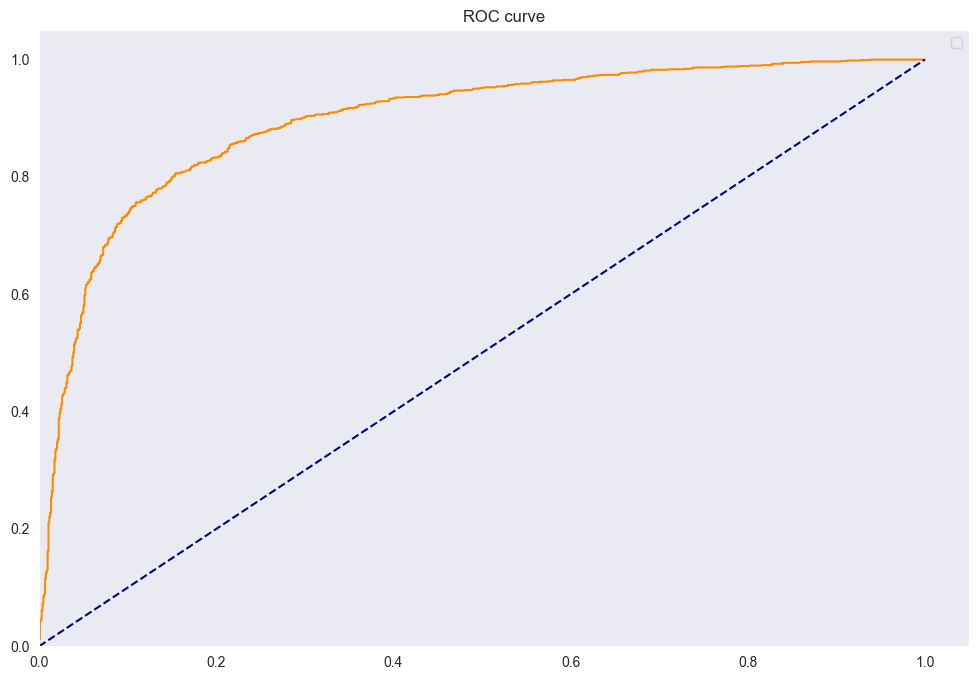

0.8952126929114502


In [101]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize = (12, 8))
plt.title('ROC curve')
plt.plot(fpr, tpr, color='darkorange',)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color='navy', linestyle='dashed')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend()
plt.show()

roc_auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
print(roc_auc_score)